# Collabortive Filtering for Recommender System

## User-item interection
For most collaborative filtering-based recommender systems, the main dataset format is a 2-D matrix called the user-item interaction matrix. In the matrix,  its row is labeled as the user id/index and column labelled to be the item id/index, and the element `(i, j)` represents the rating of user `i` to item `j`.

Below is a simple example of a user-item interaction matrix:

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module\_4/images/user_item_matrix.png)

#### KNN-based collaborative filtering

Now to determine if two users are similar, we can simply calculate the similarities between their row vectors in the interaction matrix. Then based on the similarity measurements, we can find the `k` nearest neighbor as the similar users.
Item-based collaborative filtering works similarly, we just need to look at the user-item matrix vertically. Instead of finding similar users, we are trying to find similar items (courses). If two courses are enrolled by two groups of similar users, then we could consider the two items are similar and use the known ratings from the other users to predict the unknown ratings.


In [1]:
import numpy as np
import pandas as pd
import math

In [2]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_df = pd.read_csv(rating_url)

In [3]:
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


The dataset contains three columns, user id (learner), item id(course), and rating(enrollment mode).

Note that this matrix is presented as the dense or vertical form, and you may convert it to a sparse matrix using pivot :

In [4]:
rating_sparse_df = rating_df.pivot(index='user', columns='item', values='rating').fillna(0).reset_index().rename_axis(index=None, columns=None)
rating_sparse_df.head()

,user,AI0111EN,BC0101EN,BC0201EN,BC0202EN,BD0101EN,BD0111EN,BD0115EN,BD0121EN,BD0123EN,...,SW0201EN,TA0105,TA0105EN,TA0106EN,TMP0101EN,TMP0105EN,TMP0106,TMP107,WA0101EN,WA0103EN
0,2,0.0,3.0,0.0,0.0,3.0,2.0,0.0,2.0,2.0,...,0.0,2.0,0.0,3.0,0.0,2.0,2.0,0.0,3.0,0.0
1,4,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,...,0.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0
2,5,2.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0
3,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Usually, the dense format is more preferred as it saves a lot of storage and memory space. While the benefit of the sparse matrix is it is in the nature matrix format and you could apply computations such as cosine similarity directly.

*Surprise* is a Python sci-kit library for recommender systems. It is simple and comprehensive to build and test different recommendation algorithms.

In [5]:
!pip install scikit-surprise==1.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 35.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 23.3 MB/s eta 0:00:00
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=781807 sha256=bdbc31ec7ab63cda24a1e48f98a8d7f4eb6c60cc7093fdc3e720ed07c3d38622
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [6]:
from surprise import KNNBasic
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [7]:
rating_df.to_csv("course_ratings.csv", index=False)
# Read the course rating dataset with columns user item rating
reader = Reader(
        line_format='user item rating', sep=',', skip_lines=1, rating_scale=(2, 3))

coruse_dataset = Dataset.load_from_file("course_ratings.csv", reader=reader)

In [49]:
coruse_dataset

In [8]:
#spliting dataset into training and test set
trainset, testset = train_test_split(coruse_dataset, test_size=.3)

In [9]:
print(f"Total {trainset.n_users} users and {trainset.n_items} items in the trainingset")

Total 31305 users and 123 items in the trainingset


In [10]:
# Performing KNN-based collaborative filtering on the user-item interaction matrix
sim_options = {
    "name": "cosine",
    "user_based": False,  # compute  similarities between items
}
algo = KNNBasic(sim_options=sim_options)
# - Train the KNNBasic model on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
RMSE_KNN = accuracy.rmse(predictions)
RMSE_KNN

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.1939


0.19385891811914266

### Performing NMF-based collaborative filtering on the course-interaction matrix

In [11]:
from surprise import NMF

In [12]:
# - Define a NMF model NMF
model = NMF(verbose=True, random_state=123)

# - Train the NMF on the trainset, and predict ratings for the testset
model = model.fit(trainset)
predictions = model.test(testset)


# Then compute RMSE
RMSE_NMF = accuracy.rmse(predictions)
RMSE_NMF

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
RMSE: 0.20

0.20410242809398813

### Performing SVD-based collaborative filtering on the course-interaction matrix

In [13]:
from surprise import SVD

In [15]:
# - Define a SVD model
model = SVD()

# - Train the NMF on the trainset, and predict ratings for the testset
model = model.fit(trainset)
predictions = model.test(testset)


# Then compute RMSE
RMSE_SVD = accuracy.rmse(predictions)
RMSE_SVD

RMSE: 0.2685


0.26849003034713537

### Regression-based Rating Score Prediction using Embedding Features

In [16]:
!pip install scikit-learn==1.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 30.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.20.1
    Uninstalling scikit-learn-0.20.1:
      Successfully uninstalled scikit-learn-0.20.1


In [17]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [18]:
#Loading Datasets
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
user_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_embeddings.csv"
item_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_embeddings.csv"

In [19]:
rating_df = pd.read_csv(rating_url)

In [20]:
# Load user embeddings
user_emb = pd.read_csv(user_emb_url)
# Load item embeddings
item_emb = pd.read_csv(item_emb_url)

In [21]:
user_emb.head()

,user,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,UFeature10,UFeature11,UFeature12,UFeature13,UFeature14,UFeature15
0,1889878,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,0.091464,-0.040247,0.018958,-0.153328,-0.090143,0.082830,-0.058721,0.057929,-0.001472
1,1342067,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,0.104128,-0.034401,0.004011,0.064832,0.165857,-0.004384,0.053257,0.014308,0.056684
2,1990814,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,-0.156026,0.039269,0.042195,0.014695,-0.115989,0.031158,0.102021,-0.020601,0.116488
3,380098,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,-0.060944,0.112384,0.002114,0.090660,-0.068545,0.008967,0.063962,0.052347,0.018072
4,779563,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,-0.019367,-0.031341,0.064896,-0.048158,-0.047309,-0.007544,0.010474,-0.032287,-0.083983


In [22]:
item_emb.head()

,item,CFeature0,CFeature1,CFeature2,CFeature3,CFeature4,CFeature5,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,CC0101EN,0.009657,-0.005238,-0.004098,0.016303,-0.005274,-0.000361,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,CL0101EN,-0.008611,0.028041,0.021899,-0.001465,0.006900,-0.017981,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,ML0120ENv3,0.027439,-0.027649,-0.007484,-0.059451,0.003972,0.020496,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,BD0211EN,0.020163,-0.011972,-0.003714,-0.015548,-0.007540,0.014847,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,DS0101EN,0.006399,0.000492,0.005640,0.009639,-0.005487,-0.000590,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


In [23]:
# Merge user embedding features
user_emb_merged = pd.merge(rating_df, user_emb, how='left', left_on='user', right_on='user').fillna(0)
# Merge course embedding features
merged_df = pd.merge(user_emb_merged, item_emb, how='left', left_on='item', right_on='item').fillna(0)

In [24]:
merged_df

,user,item,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,1889878,CC0101EN,3.0,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,...,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,1342067,CL0101EN,3.0,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,...,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,1990814,ML0120ENv3,3.0,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,...,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,380098,BD0211EN,3.0,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,...,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,779563,DS0101EN,3.0,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,...,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233301,1540125,DS0101EN,3.0,-0.021376,-0.081750,-0.140323,0.018257,0.070857,-0.150106,-0.101541,...,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283
233302,1250651,PY0101EN,3.0,0.038751,-0.045833,0.007787,0.054884,0.008866,-0.016915,-0.007734,...,-0.006246,-0.001485,0.007065,-0.003130,0.007294,-0.000657,0.006152,-0.001489,0.015253,0.000122
233303,1003832,CB0105ENv1,3.0,0.055601,0.032458,0.138734,-0.103575,-0.040634,0.019715,-0.024687,...,-0.004814,0.032963,-0.018020,0.013813,-0.048995,0.009753,-0.019230,-0.042314,-0.022855,0.008192
233304,922065,BD0141EN,3.0,0.098573,-0.033596,0.146387,0.002943,0.111133,-0.100475,0.097536,...,0.002402,0.003107,-0.019846,0.013243,0.010134,0.016171,-0.019714,-0.005965,-0.014285,0.006799


Next, we can combine the user features (the column labels starting with UFeature and item features (the column labels starting with CFeature. In machine learning, there are many ways to aggregate two feature vectors such as element-wise add, multiply, max/min, average, etc. Here we simply add the two sets of feature columns:

In [25]:
u_feautres = [f"UFeature{i}" for i in range(16)]
c_features = [f"CFeature{i}" for i in range(16)]

user_embeddings = merged_df[u_feautres]
course_embeddings = merged_df[c_features]
ratings = merged_df['rating']

# Aggregate the two feature columns using element-wise add
regression_dataset = user_embeddings + course_embeddings.values
regression_dataset.columns = [f"Feature{i}" for i in range(16)]
regression_dataset['rating'] = ratings
regression_dataset.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.090378,-0.134799,0.083900,0.046534,0.077417,-0.004537,-0.018561,0.079236,-0.024561,0.027359,-0.188823,-0.080762,0.050271,-0.066013,0.058894,-0.007689,3.0
1,0.059437,-0.084740,0.067107,-0.009036,-0.031482,0.050057,0.125847,0.066517,-0.053798,-0.021671,0.064212,0.204660,-0.004188,0.007914,0.027170,0.076114,3.0
2,0.152061,-0.014739,-0.080112,-0.009516,0.024130,0.153802,-0.048061,-0.119888,0.059234,0.060882,0.004244,-0.166000,0.045002,0.057566,-0.022081,0.108929,3.0
3,-0.014707,-0.011257,0.073692,0.054763,-0.050547,-0.020599,0.027146,-0.067012,0.106593,-0.020921,0.106658,-0.092025,0.024436,0.086183,0.029232,0.016287,3.0
4,0.112812,-0.001395,-0.011572,-0.032638,-0.080440,-0.057321,0.064595,-0.020880,-0.048939,0.068486,-0.031359,-0.044577,-0.002381,0.025505,-0.033164,-0.105266,3.0


In [26]:
#Selecting input X and output y vector
X = regression_dataset.iloc[:, :-1]
y = regression_dataset.iloc[:, -1]
print(f"Input data shape: {X.shape}, Output data shape: {y.shape}")

Input data shape: (233306, 16), Output data shape: (233306,)


In [27]:
#spliting dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [28]:
#creating model
model = linear_model.LinearRegression()

In [29]:
# train the model
model = model.fit(X_train,y_train)

In [30]:
# test the model
ypred = model.predict(X_test)

In [31]:
MSE_embedding = mean_squared_error(ypred,y_test)
MSE_embedding

0.044897591465488454

In [32]:
# Using RandomForest
#from sklearn.ensemble import RandomForestClassifier
from surprise import NormalPredictor

In [33]:
# - Define a model
model = NormalPredictor()

# - Train the NMF on the trainset, and predict ratings for the testset
model = model.fit(trainset)
predictions = model.test(testset)


# Then compute RMSE
RMSE_Random = accuracy.rmse(predictions)
RMSE_Random

RMSE: 0.2616


0.2616239871353421

In [34]:
from surprise import BaselineOnly

In [35]:
# - Define a model
model = BaselineOnly()

# - Train the NMF on the trainset, and predict ratings for the testset
model = model.fit(trainset)
predictions = model.test(testset)


# Then compute RMSE
RMSE_Baseline = accuracy.rmse(predictions)
RMSE_Baseline

Estimating biases using als...
RMSE: 0.1601


0.16007510133827832

In [36]:
from surprise import CoClustering

In [37]:
# - Define a model
model = CoClustering(n_cltr_u=3, n_cltr_i=3, n_epochs=20, random_state=None, verbose=False)

# - Train the NMF on the trainset, and predict ratings for the testset
model = model.fit(trainset)
predictions = model.test(testset)


# Then compute RMSE
RMSE_CoClustering = accuracy.rmse(predictions)
RMSE_CoClustering


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


RMSE: 0.2418


0.2417900600306006

In [38]:
from surprise import SlopeOne
# - Define a model
model = SlopeOne()

# - Train the NMF on the trainset, and predict ratings for the testset
model = model.fit(trainset)
predictions = model.test(testset)


# Then compute RMSE
RMSE_SlopeOne = accuracy.rmse(predictions)
RMSE_SlopeOne


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


RMSE: 0.1907


0.19066647753235155

In [44]:
Results= {"Model":["Random","Baseline","Co_clustering","KNN","SlopeOne","NMF","SVD","Embedding"],
         "RMSE": [RMSE_Random,RMSE_Baseline,RMSE_CoClustering,RMSE_KNN,RMSE_SlopeOne,RMSE_NMF,RMSE_SVD,MSE_embedding]}


In [45]:
results_df = pd.DataFrame(Results)
results_df

,Model,RMSE
0,Random,0.261624
1,Baseline,0.160075
2,Co_clustering,0.241790
3,KNN,0.193859
4,SlopeOne,0.190666
5,NMF,0.204102
6,SVD,0.268490
7,Embedding,0.044898


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

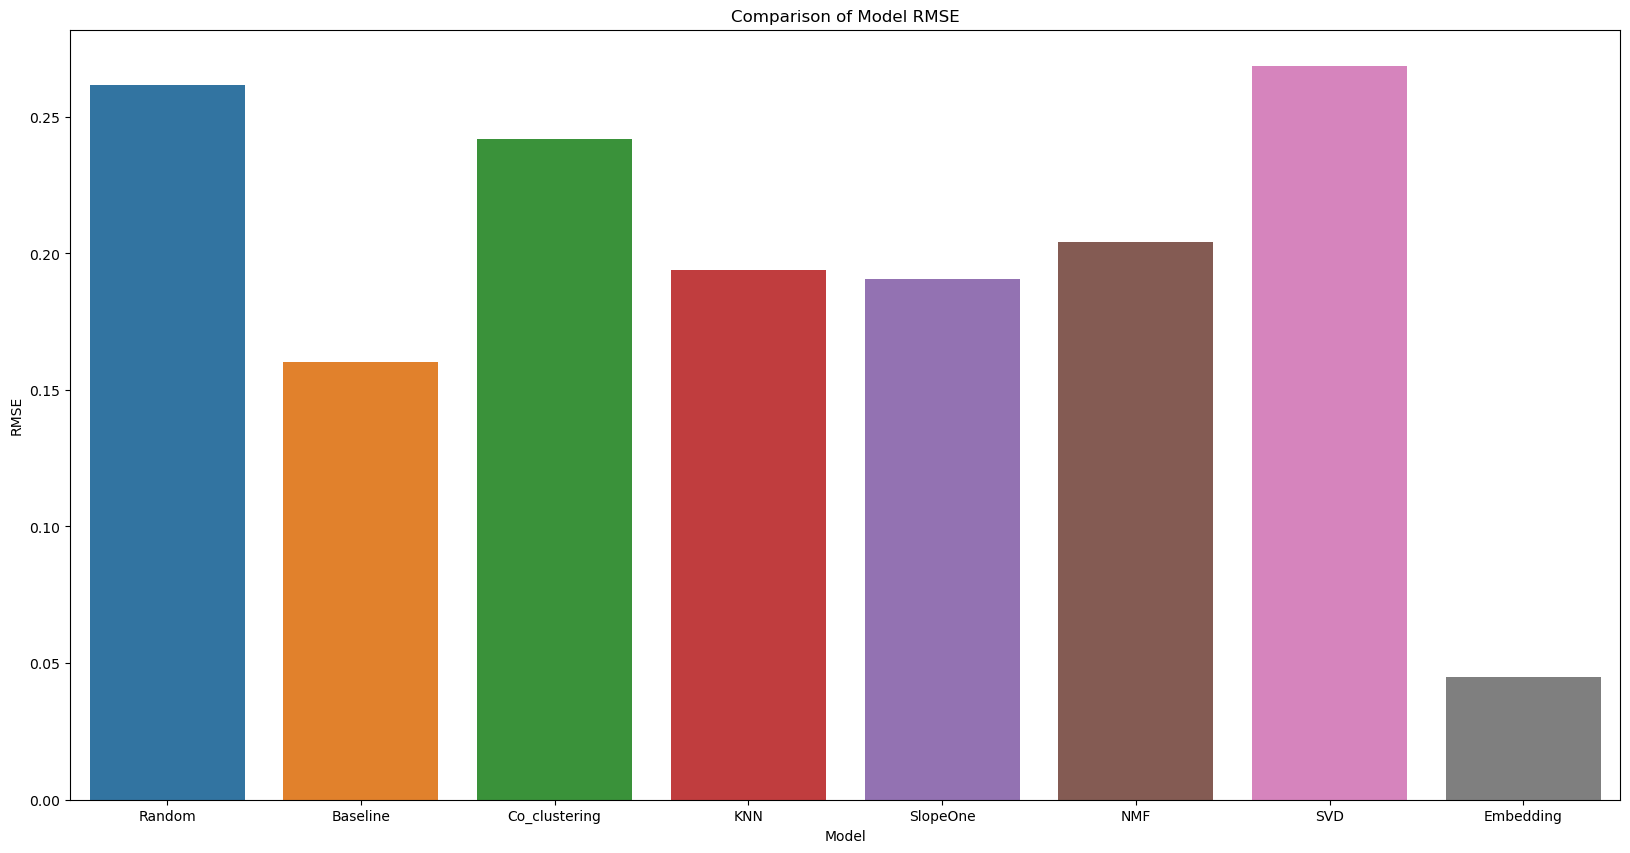

In [48]:
fig = plt.figure(figsize=(20,10))
ax = sns.barplot(x="Model", y = "RMSE", data = results_df).set(title='Comparison of Model RMSE')